<a href="https://colab.research.google.com/github/Q00/ml_category_classifier/blob/master/use_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
from sklearn.utils import shuffle


data = shuffle(pd.read_csv("./drive/My Drive/ColabNotebooks/train.csv",names=['category', 'headline'], header=None))


In [0]:
#data.map(lambda line : line.split(',')).map(lambda field: (field[0],field[1])).keys().countByValue()
#data.printSchema()
data.shape

(2224, 2)

pandas 시각화

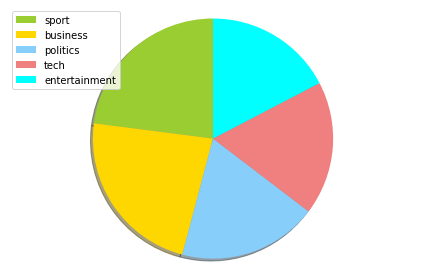

In [0]:
import pylab as pl
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline
#temp = data.groupBy('_c0').count().orderBy('count')
temp = data['category'].value_counts()

df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

padas + 사이킷러닝을 통한 svm 알고리즘 사용

In [55]:
#from sklearn.model_selection import train_test_split

#train, test = train_test_split(data, test_size=0.2)
test_df = data.sample(frac=0.3)
print(test_df.index)
test_df = test_df.reset_index()
print(test_df.index)

train_df = data.drop(test_df.index)
print(train_df.index)
train_df = train_df.reset_index()
print(train_df.index)

X_train = pd.DataFrame(train_df.drop(['category','headline'],axis=1))
#X_train = pd.DataFrame(train)
Y_train_label = train_df.category.values.astype(object)
X_test = pd.DataFrame(test_df.drop(['category','headline'],axis=1))
#X_test = pd.DataFrame(test)
Y_test_label = test_df.category.values.astype(object)
print("X_train", X_train)
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

Int64Index([ 362,  926,  664,  936,  382,   79, 1250,  795, 2053, 1359,
            ...
             999,  229, 2037, 1134, 2007,   81,  333,  171,  279,   24],
           dtype='int64', length=668)
RangeIndex(start=0, stop=668, step=1)
Int64Index([ 928,  957,  882, 1640, 1755, 2171, 1370,  731, 1474, 1706,
            ...
            1714,  842, 2030,  894, 1408, 2015, 1762, 1078, 1364, 1471],
           dtype='int64', length=1557)
RangeIndex(start=0, stop=1557, step=1)
X_train       index
0       928
1       957
2       882
3      1640
4      1755
...     ...
1552   2015
1553   1762
1554   1078
1555   1364
1556   1471

[1557 rows x 1 columns]
Dimension of Train set (1557, 1)
Dimension of Test set (668, 1) 



In [56]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)
#list(set(X_train.columns) - set(num_cols))


names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]



Number of numeric features: 1


In [59]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [60]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))


Best score for training data: 0.22928709055876687 

Best C: 1 

Best Kernel: rbf 

Best Gamma: 0.001 



In [62]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
from sklearn.metrics import confusion_matrix,classification_report


print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

svm_model.score

[[156   0   0   0   0]
 [ 99   0   0   0   0]
 [128   0   0   0   0]
 [163   0   0   0   0]
 [122   0   0   0   0]]


               precision    recall  f1-score   support

     business       0.23      1.00      0.38       156
entertainment       0.00      0.00      0.00        99
     politics       0.00      0.00      0.00       128
        sport       0.00      0.00      0.00       163
         tech       0.00      0.00      0.00       122

     accuracy                           0.23       668
    macro avg       0.05      0.20      0.08       668
 weighted avg       0.05      0.23      0.09       668

Training set score for SVM: 0.229287
Testing  set score for SVM: 0.233533


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

dataframe을 통한 머신러닝 알고리즘 사용

In [0]:

data = sqlContext.read.format('com.databricks.spark.csv').options(header='false', inferschema='true').load("./drive/My\ Drive/ColabNotebooks/train.csv")

In [0]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="_c1", outputCol="words", pattern="\\W")
# stop words
add_stopwords = ["the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

In [0]:
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


_c0 : 카테고리가 label index로 색인시작 ( 다섯가지)


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "_c0", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(10)

+-------------+--------------------+--------------------+--------------------+--------------------+-----+
|          _c0|                 _c1|               words|            filtered|            features|label|
+-------------+--------------------+--------------------+--------------------+--------------------+-----+
|         tech|tv future in the ...|[tv, future, in, ...|[tv, future, in, ...|(9447,[0,1,2,3,4,...|  3.0|
|     business|worldcom boss  le...|[worldcom, boss, ...|[worldcom, boss, ...|(9447,[0,1,2,3,4,...|  1.0|
|        sport|tigers wary of fa...|[tigers, wary, of...|[tigers, wary, of...|(9447,[0,1,2,3,4,...|  0.0|
|        sport|yeading face newc...|[yeading, face, n...|[yeading, face, n...|(9447,[0,1,2,3,4,...|  0.0|
|entertainment|ocean s twelve ra...|[ocean, s, twelve...|[ocean, s, twelve...|(9447,[0,1,2,3,4,...|  4.0|
|     politics|howard hits back ...|[howard, hits, ba...|[howard, hits, ba...|(9447,[0,1,2,3,4,...|  2.0|
|     politics|blair prepares to...|[blair, pr

In [0]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 1776
Test Dataset Count: 449


LogisticRegression 사용

In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
print(lrModel)

LogisticRegressionModel: uid = LogisticRegression_33019ad0b1fe, numClasses = 5, numFeatures = 9447


In [0]:
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 4.0) \
    .select("_c1","_c0","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 100)


+----------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------------------------------------+-----+----------+
|                                                                                                 _c1|          _c0|                                                                                         probability|label|prediction|
+----------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------------------------------------+-----+----------+
|uganda bans vagina monologues uganda s authorities have banned the play the vagina monologues  du...|entertainment|  [0.22142210008450433,0.06926105589862376,0.1771293046813308,0.09238374822022723,0.439803791115314]|  4.0|       4.0|
|soul sensation ready for awards south west teenage singing 

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9733977646698799

TF-IDF


In [0]:
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("_c1","_c1","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+------------------------------+-----+----------+
|                           _c1|                           _c1|                   probability|label|prediction|
+------------------------------+------------------------------+------------------------------+-----+----------+
|all black magic: new zealan...|all black magic: new zealan...|[0.9999128693829448,1.76278...|  0.0|       0.0|
|britain boosted by holmes d...|britain boosted by holmes d...|[0.9996848851904876,3.03167...|  0.0|       0.0|
|celts savour grand slam pro...|celts savour grand slam pro...|[0.9931376466001954,0.00124...|  0.0|       0.0|
|johnson edges out rival sot...|johnson edges out rival sot...|[0.9922290391087946,0.00204...|  0.0|       0.0|
|parry firm over gerrard lis...|parry firm over gerrard lis...|[0.9896240446379182,7.72761...|  0.0|       0.0|
|safin cool on wimbledon new...|safin cool on wimbledon new...|[0.9891740344748176,0.00166...|  0.0|    

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9688322104184124

cross-validation

In [0]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)

In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.968762659639567

Naive Bayes

In [0]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("_c1","_c0","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                           _c1|  _c0|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|bates seals takeover ken ba...|sport|[1.0,1.4405670836794528E-17...|  0.0|       0.0|
|pountney handed ban and fin...|sport|[1.0,1.5114820337199625E-28...|  0.0|       0.0|
|hereford 1-1 doncaster here...|sport|[1.0,2.1723135146840322E-33...|  0.0|       0.0|
|collins banned in landmark ...|sport|[1.0,2.0294308220167036E-33...|  0.0|       0.0|
|benitez  to launch moriente...|sport|[1.0,1.7173545683502412E-35...|  0.0|       0.0|
|tulu to appear at caledonia...|sport|[1.0,2.357169485349786E-36,...|  0.0|       0.0|
|beattie return calms attack...|sport|[1.0,3.827751047511699E-39,...|  0.0|       0.0|
|sprinter walker quits athle...|sport|[1.0,6.04513995079047E-42,5...|  0.0|       0.0|
|sociedad set to rescue mlad...|sport|[1.0,

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9711195012749292

Random Forest

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("_c1","_c0","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                           _c1|  _c0|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|mido makes third apology ah...|sport|[0.44695067375157593,0.1507...|  0.0|       0.0|
|man utd stroll to cup win w...|sport|[0.4384247371503748,0.16193...|  0.0|       0.0|
|giggs handed wales leading ...|sport|[0.438297074131562,0.164717...|  0.0|       0.0|
|federer claims dubai crown ...|sport|[0.4381960984622244,0.17055...|  0.0|       0.0|
|sella wants michalak recall...|sport|[0.436927967182787,0.160053...|  0.0|       0.0|
|unclear future for striker ...|sport|[0.4325539543138061,0.17860...|  0.0|       0.0|
|dominici backs lacklustre f...|sport|[0.4317524002345162,0.17805...|  0.0|       0.0|
|scotland v italy (sat) murr...|sport|[0.4277126386948783,0.17995...|  0.0|       0.0|
|france v wales (sat) stade ...|sport|[0.42

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8448518863348249